# Introduction



This notebook is a template for training a PPO model in fake environment. Fake environment is 

---
**NOTE**

To use this notebook, please first follow `UseGuide.md` to install the neccessary packages.

---

In [65]:
%%capture output 
# captures ALL output in cell to disable tensorflow warnings

import numpy as np
from stable_baselines import PPO1

In [66]:
import sys
sys.path.insert(0,'../backend')

# load our fakegym
from fakegym.fakeenv import WbtGymFake
from fakegym.state import FakeState

In [67]:
world_size = 10
num_obstacles = 16

In [68]:
class MyEnv(WbtGymFake):
    def __init__(self, seed=None, N=10, num_of_sensors=4, obstacles_num=16, step_range=(1, 1), obs=FakeState, obs_len=1):
                  super(MyEnv, self).__init__(seed, N, num_of_sensors, obstacles_num, step_range, obs, obs_len=obs_len)

    def calc_reward(self):
            pass
        
        
    def check_done(self):
        """Check done"""
            pass

In [69]:
# # normal
env = WbtGymFake(N=world_size, obstacles_num=num_obstacles)
env.render()

<Figure size 720x720 with 0 Axes>

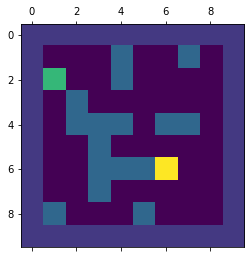

In [70]:
# custom reward class
# env = MyEnv(N=world_size, obstacles_num=num_obstacles)
# env.render()

In [71]:
%%capture output 
# captures ALL output in cell to disable tensorflow warnings

model_name = "PPO_fakeenv"
model = PPO1("MlpPolicy", env)

In [72]:
time_steps = 100
model.learn(total_timesteps=time_steps)
model.save("model/grid/{}".format(model_name))